In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import random
import os

# 스케일 처리
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import  MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# sklearn
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# keras(MLP,CNN)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, Flatten, Dense, MaxPooling1D,Reshape, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.utils import to_categorical

# SVM 
from tensorflow.keras.layers.experimental import RandomFourierFeatures


In [3]:
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-3
    epochs = 25
    batch_size = 32
    num_workers = 4
    train_5_folds = True
    
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

seed_everything(config.seed)

# 데이터 불러오기 및 전처리

In [4]:
# 스케일 변환
def X_scale(X):
    scaler = RobustScaler()
    X_scaled= scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled)
    return X_scaled

# 이상치 정리
def outlier(X):
    q1 = X.quantile(0.25)
    q3 = X.quantile(0.75)
    IQR = q3-q1
    condition = (X > (q1 - 1.5*IQR )) & (X < (q3 + 1.5*IQR ))
    X_drop = X[condition]
    X_fill = X_drop.fillna(X_drop.interpolate()) # Nan값을 앞뒤의 값의 동일 간격으로 채우기
    X_fill = X_fill.fillna(method='ffill')
    X_fill = X_fill.fillna(method='bfill')
    return X_fill

def X_array(X):
    N = X.shape[1]
    X_re = np.zeros((N, 40, 1))
    for k in range(N):
        X_re[k, :, 0]  = X.T.iloc[k,:]
    return X_re

def X_array_2D(X):
    N = X.shape[1]
    X_re = np.zeros((N, 5, 8))
    for k in range(N):
        for i in range(5):
            X_re[k, i,: ]  = X.T.iloc[k,i*5:i*5+8]
    return X_re


def Y_array(Y):
    N = Y.shape[1]
    Y_re = np.zeros((N,36))
    for k in range(N):
        Y_re[k, :] = Y.T.iloc[k,:]
    return Y_re

# y 스케일 변환
def Y_scale(Y): 
    scaler = StandardScaler()
    Y_scaled = scaler.fit_transform(Y)
    # Y_scaled = pd.DataFrame(Y_scaled)
    return scaler, Y_scaled


In [5]:
# 데이터 불러오기
B7_TM_re2 = pd.read_csv('../data/B7/B7_Ti_TM_5x8.csv')
B7_MG = pd.read_csv('../data/B7/B7_Ti_MG.csv')
V3_TM_re2 = pd.read_csv('../data/V3/V3_Ti_TM_5x8.csv')
V3_MG = pd.read_csv('../data/V3/V3_Ti_MG.csv')

# B7과 V3데이터 합치기
TM = pd.concat([B7_TM_re2 ,V3_TM_re2 ], axis=1)
MG = pd.concat([B7_MG ,V3_MG ], axis=1)

MG[MG == 755.0] = 75.5

print(TM.shape, B7_TM_re2.shape, V3_TM_re2.shape, MG.shape, B7_MG.shape, V3_MG.shape)

(40, 186) (40, 90) (40, 96) (36, 186) (36, 90) (36, 96)


In [6]:
# 스케일 처리 및 이상치 제거
X_scaled = X_scale(TM)
X_outliner = outlier(X_scaled)
X = X_array(X_outliner)
X_2D = X_array_2D(X_outliner)

Y_array = Y_array(MG)
scaler, Y = Y_scale(Y_array)

In [7]:
X

array([[[ 0.2669363 ],
        [-0.03235592],
        [ 1.02325581],
        ...,
        [ 0.32760364],
        [-0.06875632],
        [ 0.03235592]],

       [[-0.38818565],
        [-0.16455696],
        [ 0.60337553],
        ...,
        [ 0.89451477],
        [-0.25738397],
        [-0.48945148]],

       [[ 0.28512821],
        [ 0.28512821],
        [ 0.41230769],
        ...,
        [ 0.25641026],
        [ 0.20717949],
        [ 0.20717949]],

       ...,

       [[-0.20979021],
        [-0.46953047],
        [-1.09190809],
        ...,
        [ 1.78821179],
        [ 1.78821179],
        [ 1.78821179]],

       [[ 1.43352601],
        [ 0.45086705],
        [-0.47630058],
        ...,
        [ 1.51445087],
        [ 1.96531792],
        [ 1.35260116]],

       [[ 0.0296824 ],
        [-0.10092015],
        [-0.83704363],
        ...,
        [ 2.01246661],
        [ 2.01246661],
        [ 2.01246661]]])

In [8]:
Y

array([[ 1.10377263, -0.33154882,  1.36572931, ...,  1.46158879,
         0.74265175, -0.19811045],
       [ 1.10377263, -0.33154882,  1.36572931, ...,  1.46158879,
         0.74265175, -0.19811045],
       [ 4.08395872, -3.85543919,  0.6623355 , ...,  1.46158879,
        -0.76700099,  4.59987707],
       ...,
       [-0.8830181 ,  0.10893747, -1.04590662, ..., -1.13321421,
        -1.14441417, -0.39002995],
       [-0.8830181 ,  0.10893747, -1.04590662, ..., -1.13321421,
        -1.14441417, -0.77386896],
       [-0.8830181 ,  0.10893747, -1.04590662, ..., -1.13321421,
        -1.14441417, -0.77386896]])

In [6]:
Y_array

array([[71. , 84. , 83.5, ..., 80. , 84. , 67.5],
       [71. , 84. , 83.5, ..., 80. , 84. , 67.5],
       [80. , 80. , 80. , ..., 80. , 80. , 80. ],
       ...,
       [65. , 84.5, 71.5, ..., 73.5, 79. , 67. ],
       [65. , 84.5, 71.5, ..., 73.5, 79. , 66. ],
       [65. , 84.5, 71.5, ..., 73.5, 79. , 66. ]])

In [7]:
print('X의 shape: ', X.shape ,', Y의 shape:',Y.shape)

X의 shape:  (186, 40, 1) , Y의 shape: (186, 36)


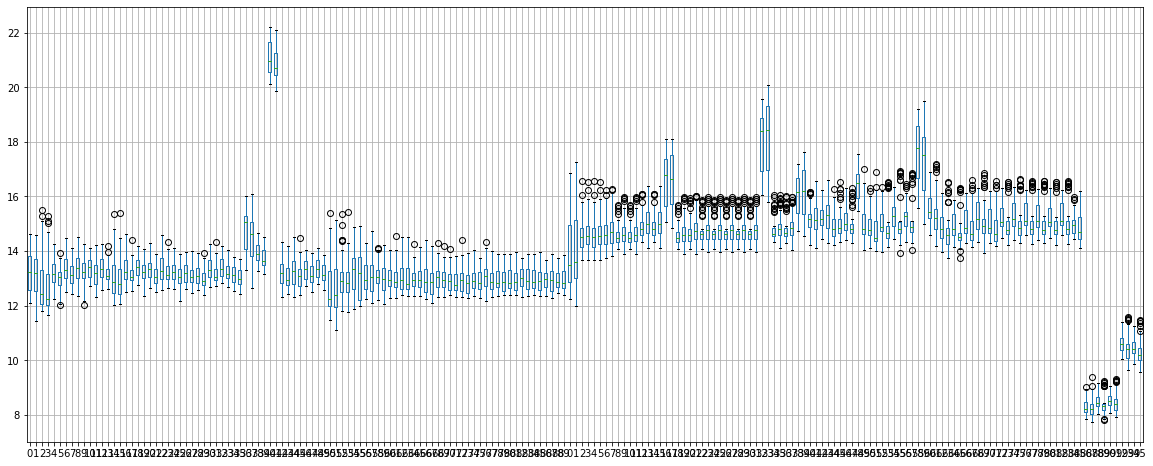

In [8]:
plt.figure(figsize=(20,8))
TM.boxplot()
plt.show()

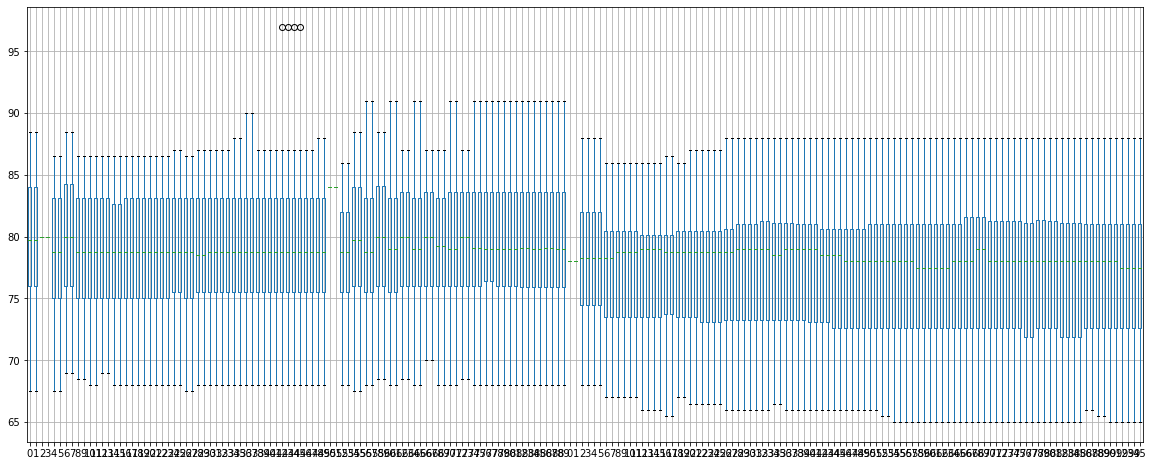

In [9]:
plt.figure(figsize=(20,8))
MG.boxplot()
plt.show()

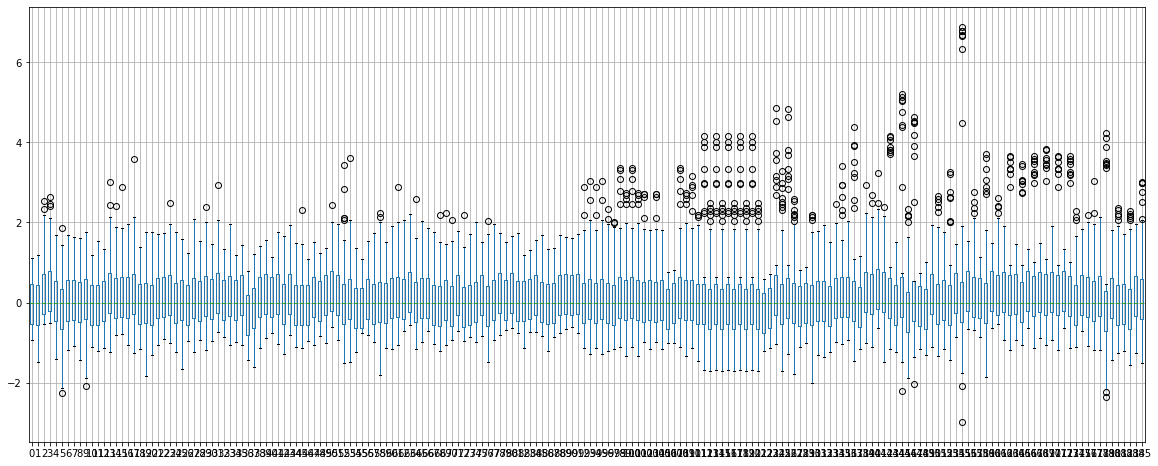

In [10]:
plt.figure(figsize=(20,8))
X_scaled.boxplot()
plt.show()

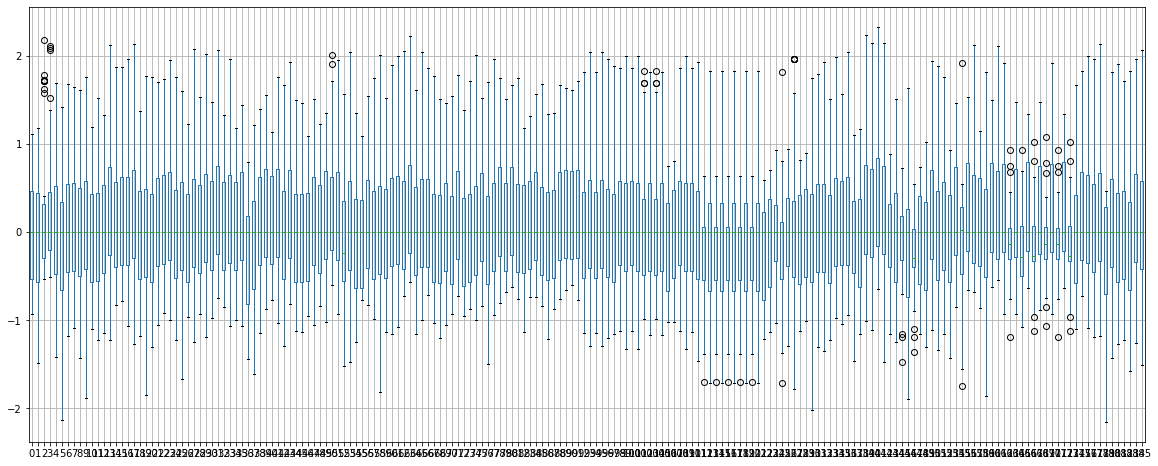

In [11]:
plt.figure(figsize=(20,8))
X_outliner.boxplot()
plt.show()

# 모델평가 함수 정의

In [12]:
def test_pred_plot(list,y_test, y_pred): 

    x_ax = range(36)

    plt.subplots(constrained_layout=True)
    for i,k in zip(range(1,5),list):
        plt.subplot(2,2,i)
        plt.plot(x_ax, y_test[k], label="test", color='y')
        plt.plot(x_ax, y_pred[k], label="pred", color='c')
        plt.legend()
        plt.title(k)
        plt.ylabel('MG Height')
        plt.xlabel('location')
    plt.show()

In [13]:
def test_pred_mean_plot(y_test, y_pred): 
    x_ax = range(36)
    plt.plot(x_ax, pd.DataFrame(y_test).mean(), label="test_mean", color='r')
    plt.plot(x_ax, pd.DataFrame(y_pred).mean(), label="pred_mean", color='b')
    #plt.ylim(-0.2,0.2)
    plt.legend()
    plt.ylabel('MG Height')
    plt.xlabel('location')
    plt.show()

In [14]:
def scaler_inv(y_test, y_pred):
    y_test_rev = scaler.inverse_transform(y_test)
    df_y_test = pd.DataFrame(y_test_rev.T)
    y_pred_rev = scaler.inverse_transform(y_pred)
    df_y_pred = pd.DataFrame(y_pred_rev.T)
    return y_test_rev, y_pred_rev, df_y_test, df_y_pred

# MLP

In [15]:
def model_MLP(X_train, y_train):

    model = Sequential()
    model.add(Flatten(input_shape=(40,1)))
    model.add(Dense(416, activation='relu')) 
    model.add(Dense(416, activation='relu'))
    model.add(Dense(480, activation='relu'))
    model.add(Dense(36 , activation=keras.layers.LeakyReLU(alpha=0.3)))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train, batch_size=128, 
                        epochs=200, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (148, 40, 1) , X_test의 shape: (38, 40, 1) , y_train의 shape:  (148, 36) , y_test의 shape: (38, 36)
X_train의 shape:  (118, 40, 1) , X_test의 shape: (30, 40, 1) , y_train의 shape:  (118, 36) , y_test의 shape: (30, 36)


In [17]:
model, history = model_MLP(X_train, y_train)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 1.1425 - mae: 0.7846 - val_loss: 0.8467 - val_mae: 0.7316
Epoch 2/200
1/1 [==============================] - 0s 24ms/step - loss: 1.0843 - mae: 0.7587 - val_loss: 0.7914 - val_mae: 0.7026
Epoch 3/200
1/1 [==============================] - 0s 23ms/step - loss: 1.0284 - mae: 0.7335 - val_loss: 0.7280 - val_mae: 0.6654
Epoch 4/200
1/1 [==============================] - 0s 23ms/step - loss: 0.9664 - mae: 0.7027 - val_loss: 0.6656 - val_mae: 0.6256
Epoch 5/200
1/1 [==============================] - 0s 25ms/step - loss: 0.8999 - mae: 0.6701 - val_loss: 0.6122 - val_mae: 0.5899
Epoch 6/200
1/1 [==============================] - 0s 23ms/step - loss: 0.8330 - mae: 0.6437 - val_loss: 0.5727 - val_mae: 0.5682
Epoch 7/200
1/1 [==============================] - 0s 24ms/step - loss: 0.7655 - mae: 0.6256 - val_loss: 0.5417 - val_mae: 0.5507
Epoch 8/200
1/1 [==============================] - 0s 23ms/step - loss: 0.6956 - mae: 0.6031

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 416)               17056     
                                                                 
 dense_1 (Dense)             (None, 416)               173472    
                                                                 
 dense_2 (Dense)             (None, 480)               200160    
                                                                 
 dense_3 (Dense)             (None, 36)                17316     
                                                                 
Total params: 408,004
Trainable params: 408,004
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Loss')

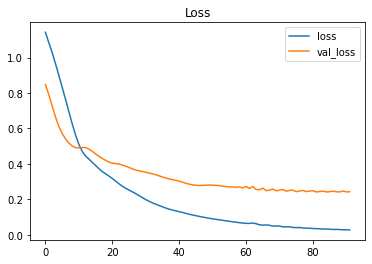

In [19]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')

## result

In [20]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

2/2 [==============================] - 0s 2ms/step
mae: 0.25963732098066866 mse: 0.15699582213052932 rmse: 0.39622698309243065 r2: 0.7450421790272933


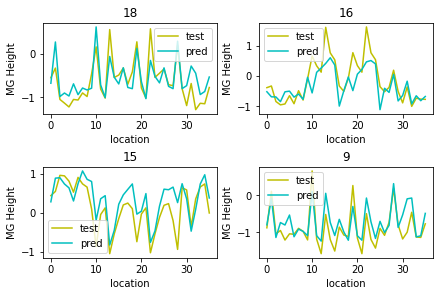

In [21]:
res = random.sample(range(1, y_test.shape[0]), 4)

test_pred_plot(res,y_test, y_pred)


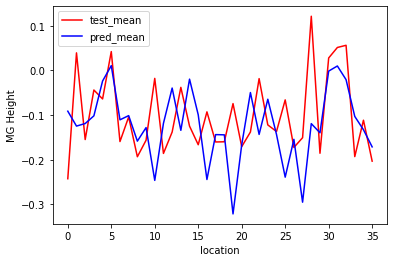

In [22]:
test_pred_mean_plot(y_test, y_pred)

In [23]:
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

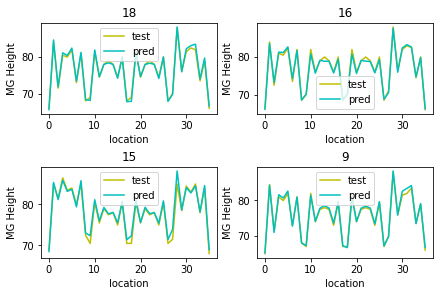

In [24]:
test_pred_plot(res, df_y_test, df_y_pred)

In [25]:
print('mae:',mean_absolute_error(y_test_rev, y_pred_rev), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev)), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae: 0.46623046607301943 rmse: 0.7873059128007821 r2: 0.7450422170431216


In [26]:
print('mae(%):',mean_absolute_error(y_test_rev, y_pred_rev)/y_test_rev.mean(), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))/y_test_rev.mean(), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae(%): 0.006011822602073592 rmse: 0.010151939492904424 r2: 0.7450422170431216


# SVM

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (148, 40, 1) , X_test의 shape: (38, 40, 1) , y_train의 shape:  (148, 36) , y_test의 shape: (38, 36)
X_train의 shape:  (118, 40, 1) , X_test의 shape: (30, 40, 1) , y_train의 shape:  (118, 36) , y_test의 shape: (30, 36)


In [28]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import RandomFourierFeatures

def model_SVM(X_train, y_train):
    n_timesteps = 40
    n_features = 1
    n_outputs = 36

    model = Sequential()
    model.add(Reshape((40,), input_shape=(n_timesteps,n_features)))
    model.add(keras.Input(shape=(40,)))
    model.add(RandomFourierFeatures(output_dim=992, scale=7.0, kernel_initializer="Gaussian"))
    model.add(Dense(n_outputs))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train, batch_size=128, 
                        epochs=200, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [29]:
model, history = model_SVM(X_train, y_train)

Epoch 1/200
1/1 [==============================] - 0s 391ms/step - loss: 1.9615 - mae: 1.0521 - val_loss: 1.1534 - val_mae: 0.8307
Epoch 2/200
1/1 [==============================] - 0s 27ms/step - loss: 1.4484 - mae: 0.8731 - val_loss: 0.9818 - val_mae: 0.7748
Epoch 3/200
1/1 [==============================] - 0s 25ms/step - loss: 1.2589 - mae: 0.8122 - val_loss: 0.9264 - val_mae: 0.7529
Epoch 4/200
1/1 [==============================] - 0s 27ms/step - loss: 1.1882 - mae: 0.7856 - val_loss: 0.8916 - val_mae: 0.7311
Epoch 5/200
1/1 [==============================] - 0s 28ms/step - loss: 1.1408 - mae: 0.7620 - val_loss: 0.8468 - val_mae: 0.7006
Epoch 6/200
1/1 [==============================] - 0s 27ms/step - loss: 1.0854 - mae: 0.7331 - val_loss: 0.7934 - val_mae: 0.6706
Epoch 7/200
1/1 [==============================] - 0s 25ms/step - loss: 1.0216 - mae: 0.7030 - val_loss: 0.7361 - val_mae: 0.6427
Epoch 8/200
1/1 [==============================] - 0s 26ms/step - loss: 0.9530 - mae: 0.6

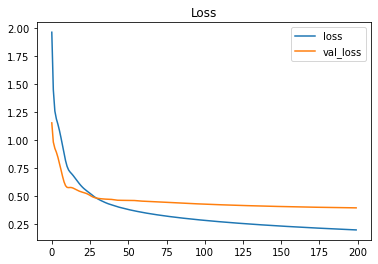

In [30]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

## result

In [31]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),  'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

2/2 [==============================] - 0s 3ms/step
mae: 0.3539984604856883 mse: 0.22580439469992145 rmse: 0.47518879900511274 r2: 0.606197257675952


In [32]:
y_train

array([[-0.55188631, -0.33154882, -0.84493696, ..., -0.73401375,
        -0.76700099, -0.77386896],
       [ 0.44150905,  0.54942377,  0.96378999, ...,  0.66318786,
         0.74265175, -0.00619095],
       [ 0.11037726,  0.10893747,  0.96378999, ...,  0.86278809,
         0.74265175, -0.00619095],
       ...,
       [-0.8830181 ,  0.10893747, -1.04590662, ..., -1.13321421,
        -1.14441417, -0.77386896],
       [ 0.11037726,  0.10893747,  0.96378999, ...,  0.86278809,
         0.74265175, -0.00619095],
       [ 1.10377263, -0.33154882,  0.96378999, ...,  0.66318786,
         0.74265175,  0.18572855]])

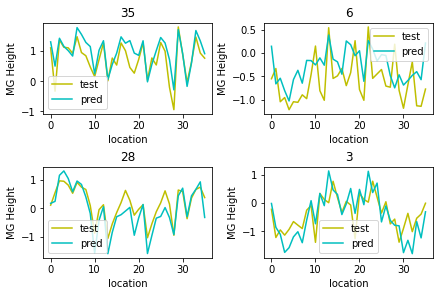

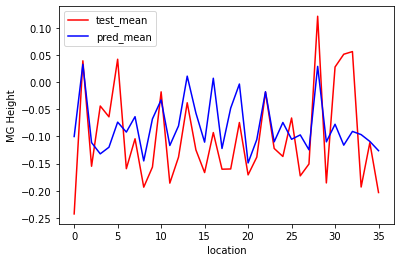

In [33]:
res = random.sample(range(1, y_test.shape[0]), 4)
test_pred_plot(res,y_test, y_pred)
test_pred_mean_plot(y_test, y_pred)

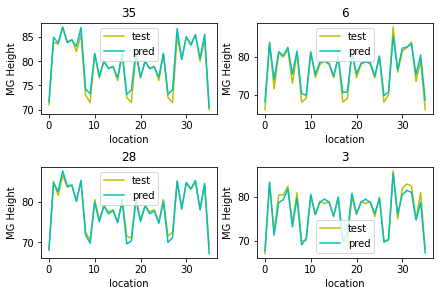

mae: 0.6336470168933533 rmse: 0.9211859728882867 r2: 0.606197119289085


In [34]:
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

test_pred_plot(res, df_y_test, df_y_pred)
#test_pred_mean_plot(df_y_test, df_y_pred)

print('mae:',mean_absolute_error(y_test_rev, y_pred_rev), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev)), 'r2:',r2_score(y_test_rev, y_pred_rev))

In [35]:
print('mae(%):',mean_absolute_error(y_test_rev, y_pred_rev)/y_test_rev.mean(), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))/y_test_rev.mean(), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae(%): 0.008170580292578646 rmse: 0.011878259906883928 r2: 0.606197119289085


# 1D-CNN

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (148, 40, 1) , X_test의 shape: (38, 40, 1) , y_train의 shape:  (148, 36) , y_test의 shape: (38, 36)
X_train의 shape:  (118, 40, 1) , X_test의 shape: (30, 40, 1) , y_train의 shape:  (118, 36) , y_test의 shape: (30, 36)


In [37]:
def model_1D_CNN(X_train, y_train):
    input_shape = (5,8,1)
    n_outputs = 36
    
    model = Sequential()
    model.add(Conv1D(filters=112, kernel_size= 3, input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(filters=112, kernel_size= 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    '''
    model.add(Conv1D(filters=96, kernel_size= 4,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    '''
    #model.add(MaxPooling2D(pool_size=(3,3), padding='same'))

    model.add(Flatten())
    model.add(Dense(96))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(80))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dense(n_outputs,activation='linear'))
    model.add(Dense(n_outputs,activation=keras.layers.LeakyReLU(alpha=0.55)))



    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train, batch_size=128, 
                        epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [38]:
def model_1D_CNN(X_train, y_train):
    n_timesteps = 40
    n_features = 1
    n_outputs = 36
    n_kernel_size = 3

    model = Sequential()
    model.add(Conv1D(filters=112, kernel_size= 5, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Flatten())
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(96, activation='relu'))
    #model.add(Dense(n_outputs,activation='linear'))
    model.add(Dense(n_outputs,activation=keras.layers.LeakyReLU(alpha=0.4))) # , activation=None
    model.summary()


    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train, batch_size=128, 
                        epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [39]:
model, history = model_1D_CNN(X_train, y_train)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 112)           672       
                                                                 
 flatten_1 (Flatten)         (None, 4032)              0         
                                                                 
 dense_5 (Dense)             (None, 80)                322640    
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_6 (Dense)             (None, 96)                7776      
                                                                 
 dense_7 (Dense)             (None, 36)                3492      
                                                                 
Total params: 334,580
Trainable params: 334,580
Non-tr

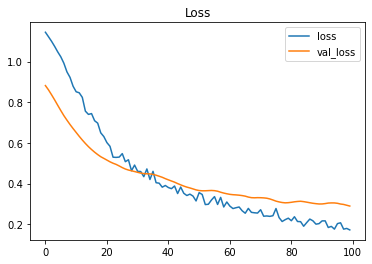

In [40]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

## result

In [41]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

2/2 [==============================] - 0s 21ms/step
mae: 0.2756229339168852 mse: 0.1572881409880299 rmse: 0.3965956895731847 r2: 0.743998394634656


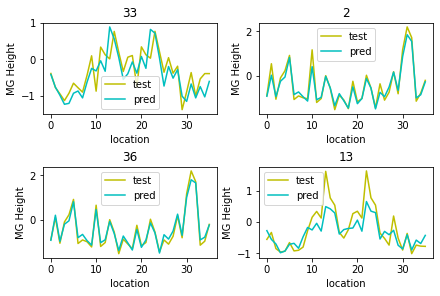

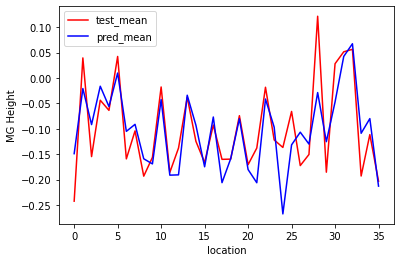

In [42]:
res = random.sample(range(1, y_test.shape[0]), 4)
test_pred_plot(res,y_test, y_pred)
test_pred_mean_plot(y_test, y_pred)

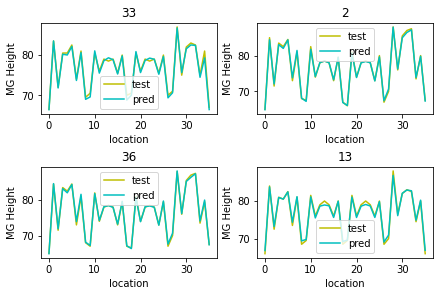

mae: 0.4902315374006304 rmse: 0.7837577433704598 r2: 0.7439983524707676


In [43]:
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

test_pred_plot(res, df_y_test, df_y_pred)
#test_pred_mean_plot(df_y_test, df_y_pred)

print('mae:',mean_absolute_error(y_test_rev, y_pred_rev), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev)), 'r2:',r2_score(y_test_rev, y_pred_rev))

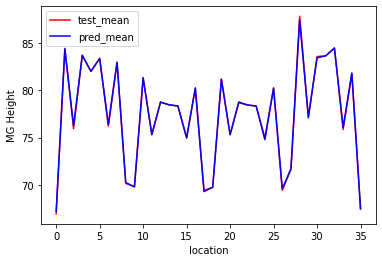

In [44]:
test_pred_mean_plot(df_y_test.T, df_y_pred.T)

In [45]:
print('mae(%):',mean_absolute_error(y_test_rev, y_pred_rev)/y_test_rev.mean(), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))/y_test_rev.mean(), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae(%): 0.0063213051296669605 rmse: 0.010106187516726494 r2: 0.7439983524707676


# 2D-CNN

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_2D, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (148, 5, 8) , X_test의 shape: (38, 5, 8) , y_train의 shape:  (148, 36) , y_test의 shape: (38, 36)
X_train의 shape:  (118, 5, 8) , X_test의 shape: (30, 5, 8) , y_train의 shape:  (118, 36) , y_test의 shape: (30, 36)


In [47]:
from tensorflow.keras.layers import Embedding, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation

def model_2D_CNN(X_train, y_train):
    input_shape = (5,8,1)
    n_outputs = 36
    
    model = Sequential()
    model.add(Conv2D(96, (3,3), input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (4,4) ,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(80, (4,4),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(3,3), padding='same'))

    model.add(Flatten())
    model.add(Dense(48))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(48))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dense(n_outputs,activation='linear'))
    model.add(Dense(n_outputs,activation=keras.layers.LeakyReLU(alpha=0.4)))


    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train, batch_size=128, 
                        epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [48]:
from tensorflow.keras.layers import Embedding, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

def model_2D_CNN(X_train, y_train):
    input_shape = (5,8,1)
    n_outputs = 36
    
    model = Sequential()
    model.add(Conv2D(96, (3,3), activation='relu', input_shape = input_shape))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
   # model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #model.add(Dense(n_outputs,activation='linear'))
    model.add(Dense(n_outputs,activation=keras.layers.LeakyReLU(alpha=0.4)))



    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train, batch_size=128, 
                        epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [49]:
model, history = model_2D_CNN(X_train, y_train)

Epoch 1/100
1/1 [==============================] - 1s 809ms/step - loss: 1.1466 - mae: 0.7852 - val_loss: 0.8834 - val_mae: 0.7466
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: 1.1255 - mae: 0.7765 - val_loss: 0.8655 - val_mae: 0.7374
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 1.1070 - mae: 0.7680 - val_loss: 0.8450 - val_mae: 0.7256
Epoch 4/100
1/1 [==============================] - 0s 32ms/step - loss: 1.0867 - mae: 0.7577 - val_loss: 0.8208 - val_mae: 0.7118
Epoch 5/100
1/1 [==============================] - 0s 30ms/step - loss: 1.0626 - mae: 0.7456 - val_loss: 0.7928 - val_mae: 0.6954
Epoch 6/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0339 - mae: 0.7313 - val_loss: 0.7624 - val_mae: 0.6773
Epoch 7/100
1/1 [==============================] - 0s 28ms/step - loss: 1.0020 - mae: 0.7154 - val_loss: 0.7308 - val_mae: 0.6582
Epoch 8/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9678 - mae: 0.6

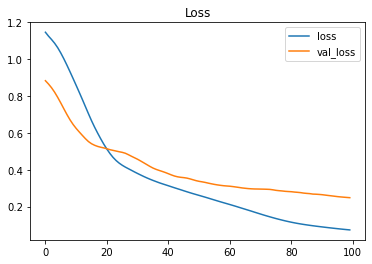

In [50]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

## result

In [51]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

2/2 [==============================] - 0s 25ms/step
mae: 0.2915313608643726 mse: 0.18520503255743526 rmse: 0.43035454285674185 r2: 0.68255865100309


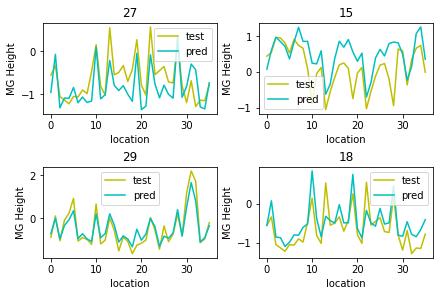

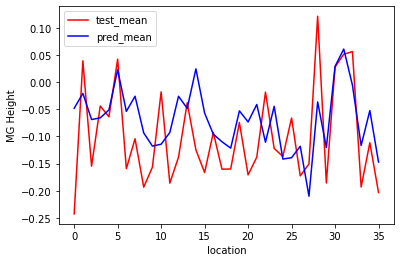

In [52]:
res = random.sample(range(1, y_test.shape[0]), 4)
test_pred_plot(res,y_test, y_pred)
test_pred_mean_plot(y_test, y_pred)

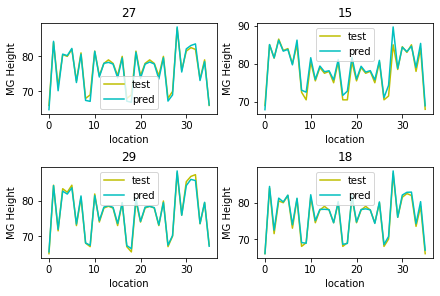

In [53]:
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

test_pred_plot(res, df_y_test, df_y_pred)
#test_pred_mean_plot(df_y_test, df_y_pred)

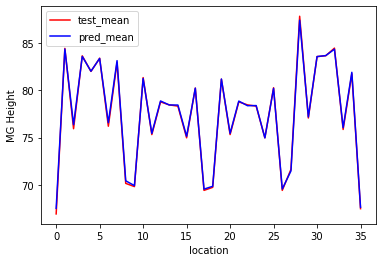

In [54]:
test_pred_mean_plot(df_y_test.T, df_y_pred.T)

In [55]:
print('mae:',mean_absolute_error(y_test_rev, y_pred_rev), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev)), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae: 0.5265157420732822 rmse: 0.8679729791295996 r2: 0.6825585755491392


In [56]:
print('mae(%):',mean_absolute_error(y_test_rev, y_pred_rev)/y_test_rev.mean(), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))/y_test_rev.mean(), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae(%): 0.006789172885257066 rmse: 0.01119210337726672 r2: 0.6825585755491392


## 시각화

In [57]:
def Y_array_2D(X):
    N = X.shape[1]
    X_re = np.zeros((N, 4, 9))
    for k in range(N):
        for i in range(4):
            X_re[k, i,: ]  = X.T.iloc[k,i*4:i*4+9]
    return X_re

# Y_array()
test_ar = Y_array_2D(df_y_test)
pred_ar = Y_array_2D(df_y_pred)

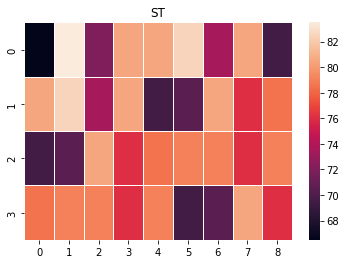

In [58]:
sns.heatmap(test_ar[0], linewidth=0.5)
plt.title('ST')
plt.show()

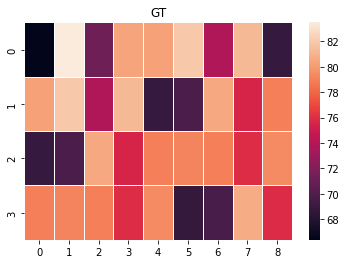

In [59]:
sns.heatmap(pred_ar[0], linewidth=0.5)
plt.title('GT')
plt.show()

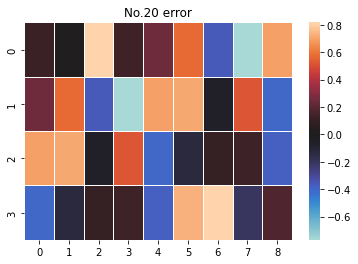

In [60]:
i = 0
sns.heatmap(test_ar[i] - pred_ar[i], linewidth=0.5, center=0)
plt.title('No.20 error')
plt.show()

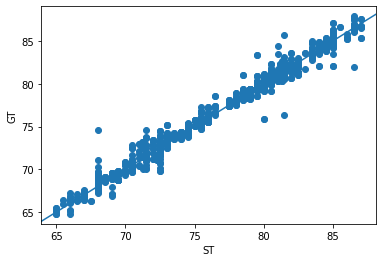

In [61]:
plt.scatter(test_ar,pred_ar)
plt.axline((65, 65), slope=1)
plt.ylabel('GT')
plt.xlabel('ST')
plt.show()

In [62]:
test_ar[0][0]

array([66.5, 83.5, 72. , 80.5, 80.5, 82.5, 73.5, 80.5, 69.5])

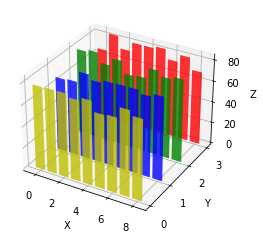

In [63]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = ['r', 'g', 'b', 'y']
yticks = [3, 2, 1, 0]

for c, k, j in zip(colors, yticks, range(4)):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(9)
    ys = test_ar[0][j]

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    #cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)

plt.show()

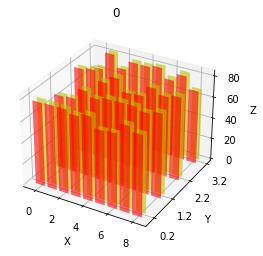

In [64]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = ['r', 'r', 'r', 'r']
yticks = [3, 2, 1, 0]
for c, k, j in zip(colors, yticks, range(4)):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(9)
    ys = test_ar[0][j]

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    #cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.6)

colors = ['y', 'y', 'y', 'y']
yticks = [3.2, 2.2, 1.2, 0.2]
for c, k, j in zip(colors, yticks, range(4)):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(9)
    ys = pred_ar[0][j]

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    #cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.6)
 
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)
plt.title('0')
plt.show()

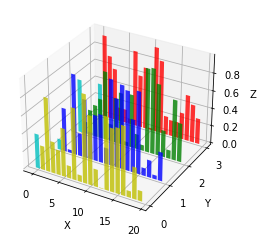

In [65]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = ['r', 'g', 'b', 'y']
yticks = [3, 2, 1, 0]
for c, k in zip(colors, yticks):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(20)
    ys = np.random.rand(20)

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)

plt.show()

# ResNet

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_2D, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (148, 5, 8) , X_test의 shape: (38, 5, 8) , y_train의 shape:  (148, 36) , y_test의 shape: (38, 36)
X_train의 shape:  (118, 5, 8) , X_test의 shape: (30, 5, 8) , y_train의 shape:  (118, 36) , y_test의 shape: (30, 36)


In [67]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    '''
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    '''
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [68]:
def ResNet50CL(input_shape = (5,8,1), classes = 10):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 64, (3,3)) #conv
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(36, activation = 'softmax')(X) # ouput layer (10 class)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet50CL")
    
    return model

In [69]:
def ResNet50C(input_shape = (5,8,1), classes = 10):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 64, (3,3)) #conv
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
   
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    '''
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    '''
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(36, activation = keras.layers.LeakyReLU(alpha=0.4))(X) # ouput layer (10 class)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet50C")
    
    return model

In [70]:
model = ResNet50C()
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "ResNet50C"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 8, 1)]    0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 8, 64)     640         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 5, 8, 64)    256         ['conv2d_1[0][0]']               
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 5, 8, 64)     0           ['batch_normalization[0][

In [71]:
EPOCH = 50
BATCH_SIZE = 4

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                              patience=10, 
                             )

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
)


In [72]:
history = model.fit(X_train, y_train,
                 validation_data=(X_val, y_val), 
                 epochs=EPOCH, 
                 batch_size=BATCH_SIZE, 
                 callbacks=[reduceLR, earlystopping],)

Epoch 1/50
30/30 [==============================] - 3s 32ms/step - loss: 1.4178 - mae: 0.8460 - val_loss: 1.0572 - val_mae: 0.8034 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - 1s 17ms/step - loss: 0.7376 - mae: 0.6365 - val_loss: 1.0388 - val_mae: 0.7978 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6578 - mae: 0.5658 - val_loss: 1.1783 - val_mae: 0.8522 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6665 - mae: 0.5927 - val_loss: 1.2112 - val_mae: 0.8748 - lr: 0.0010
Epoch 5/50
30/30 [==============================] - 1s 17ms/step - loss: 0.5894 - mae: 0.5328 - val_loss: 0.9696 - val_mae: 0.7861 - lr: 0.0010
Epoch 6/50
30/30 [==============================] - 1s 17ms/step - loss: 0.4243 - mae: 0.4529 - val_loss: 0.9358 - val_mae: 0.7742 - lr: 0.0010
Epoch 7/50
30/30 [==============================] - 1s 17ms/step - loss: 0.5594 - mae: 0.5167 - val_loss: 0.9083 - val_mae: 0.7424 - lr:

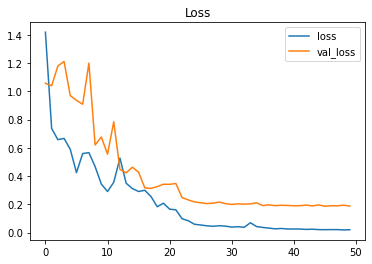

In [73]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

In [74]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

2/2 [==============================] - 0s 35ms/step
mae: 0.2419044367018932 mse: 0.14777336198932653 rmse: 0.384413009651503 r2: 0.7533293869244845


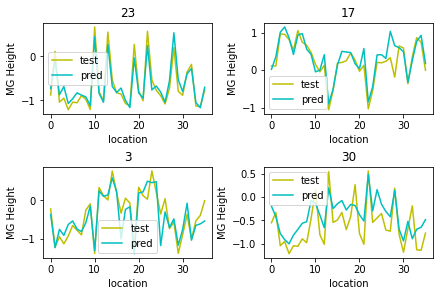

In [75]:
res = random.sample(range(1, y_test.shape[0]), 4)
test_pred_plot(res,y_test, y_pred)

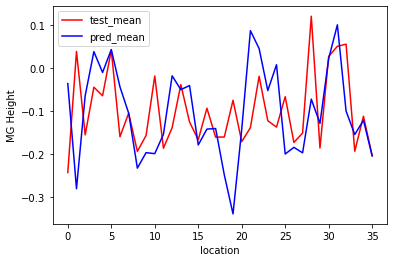

In [76]:
test_pred_mean_plot(y_test, y_pred)

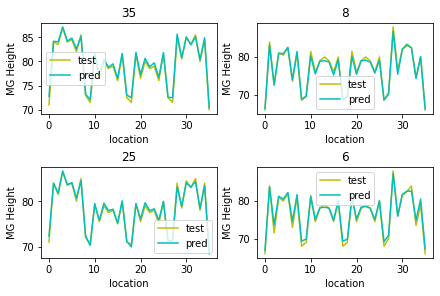

In [77]:
res = random.sample(range(1, y_test.shape[0]), 4)
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

test_pred_plot(res, df_y_test, df_y_pred)
#test_pred_mean_plot(df_y_test, df_y_pred)